# CH05

# RNN

## feed foward -> time series data를 잘 다루지 못함 

##  -> Recurrent Neural Network(RNN)의 등장 

##  wrod2vec -> 주변 맥락으로부터 타깃을 추측 (이 때 맥락의 크기는 hyperparameter)

## Language model (언어 모델 ) -> 단어의 나열에 확률을 부여 

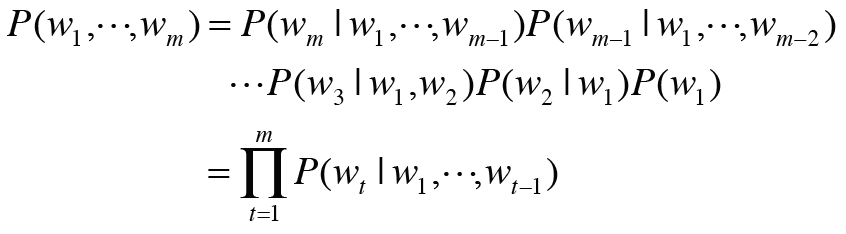

# CBOW model -> 맥락의 순서를 무시 but RNN -> 맥락의 순서 고려 

## RNN 신경망 구조

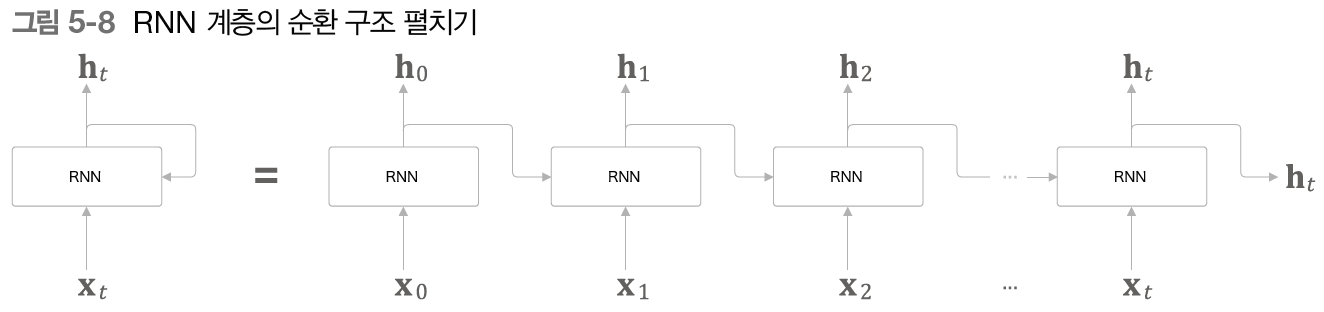

# Activation function 
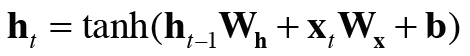

#  BPTT -> 순환신경망에서의 오차역전파

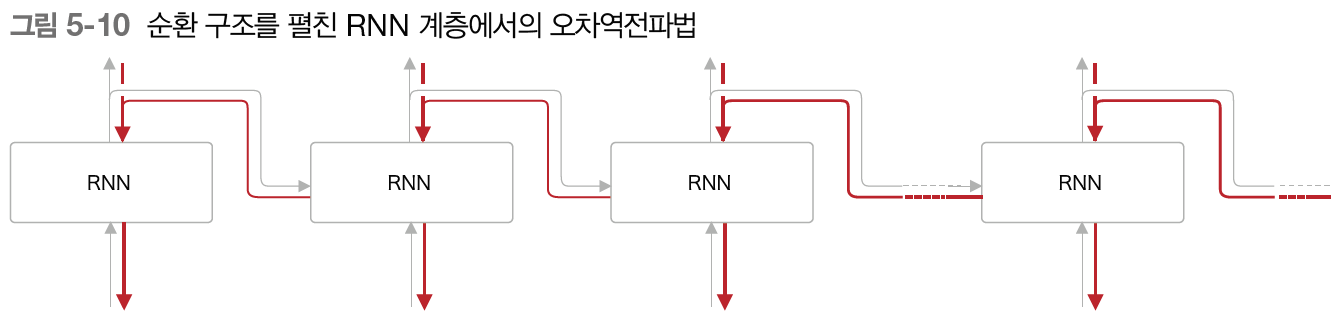

# 문제점 : 매우 긴 순환구조를 가진 데이터에 대해 오차역전파시 기울기 불안정

# 대안 -> Truncated BPTT

# RNN class 구현

In [1]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    

# Backpropargation 구현

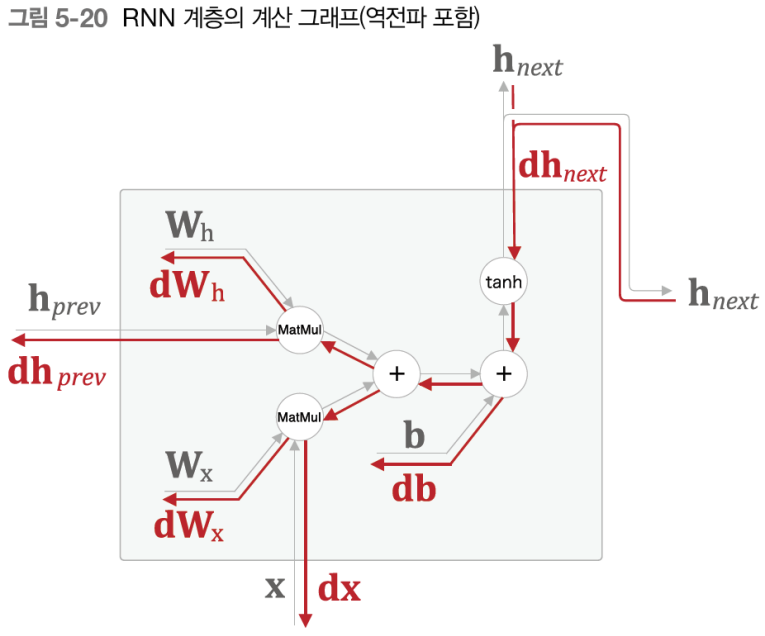

In [3]:
def backward(self, df_next):
    Wx, Wh, b = self.params
    x, h_rpev, h_next = self.cache
    
    dt = dh_next*(1-h_next**2)
    db = np.sum(dt,axis=0)
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)
    
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    
    return dx, dh_prev


# Time RNN : T개의 RNN 계층으로 구성됨 (T는 사용자 지정)

# stateful -> 은닉상태를 인계받을지 여부를 결정 

# Time RNN class 구현 

In [4]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        
        self.h, self,dh = None, None
        self.stateful = stateful
        
        def sef_state(self, h):
            self.h = h
            
        def reset_state(self):
            self.h = None

# 순전파 구현

In [6]:
def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape # N: 미니배치 크기, D: 입력벡터의 차원의 수, T: T개의 시계열 데이터
    D, H = Wx.shape
    
    self_layers = []
    hs = np.empty((N, T, H), dtype = "f")
    
    if not self.stateful or self.h is None:
        self.h = np.zeros((N, H), dtype = "f")
        
    for t in range(T):
        layer = RNN(*self.params)
        self.h = layer.forward(xs[:, t, :], self.h)
        hs[:, t, :] = self.h
        self.layers.append(layer)
        
        return hs

# 역전파 구현

In [ ]:
def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape
    
    dxs = np.empty((N, T, D), dtype= "f")
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)):
        layer = self.layers[t]
        dx, dh = layer.backward(dhs[:, t, :]+ dh)
        dxs[:, t, :] = dx
        
        for i, grad in enumerate(layer.grads):
            grads[i] +=grads
            
    for i, grad in enumerate(grads):
        self.grads[i][...] = grad
    self.dh = dh
    
    return dxs

# RNNLM의 신경망

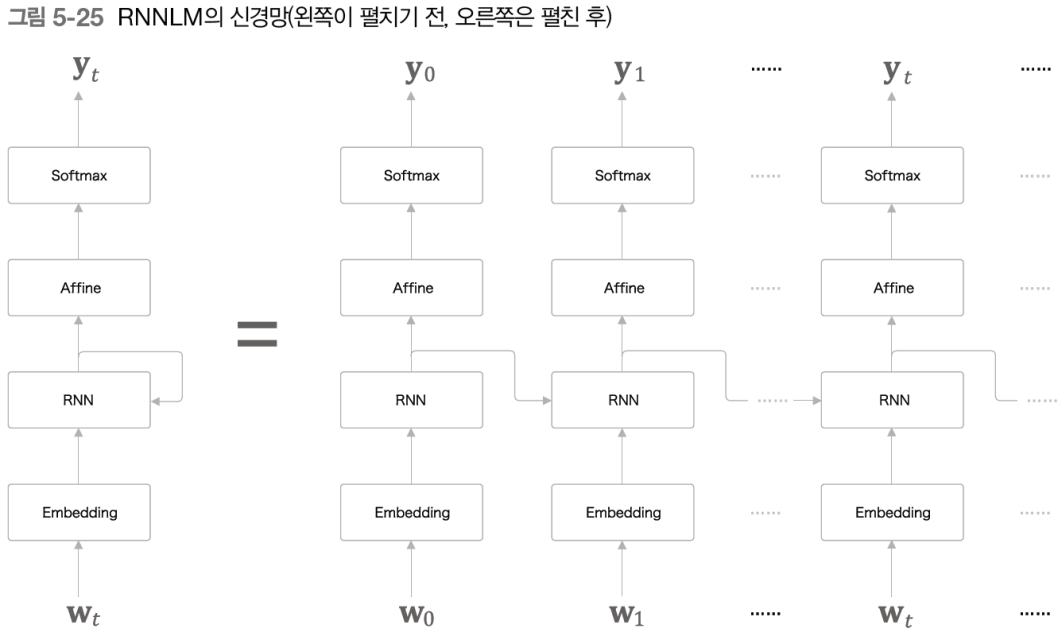

## 입력데이터 -> 단어 ID 배열

# RNNLM 구현

In [9]:
import sys 
sys.path.append("..")
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __inint__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D)/ 100).astype("f")
        rnn_Wx = (rn(D, H)/ np.sqrt(D)).astype("f") # Xaiver 초기값 사용
        rnn_Wh = (rn(H, H)/ np.sqrt(H)).astype("f")
        rnn_b = np.zeros(H).astype("f")
        affine_W = (rn(H, V)/ np.sqrt(H)).astype("f")
        affine_b = np.zeros(V).astype("f")
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ] # Truncated BPTT로 학습한다고 가정 -> stateful = TRue
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다
        
        self.params, self.grads =[], []
        for layer in self.layers:
            self.params += layers.params
            self.grads += layer.grads

# forward, backward, reset_state() 구현

In [10]:
def forward(self, xs, ts):
    for layer in self.layer:
        xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs, ts)
    return loss

def backward(self, dout =1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
        dout = layer.backward(dout)
    return dout

def reset_state(self):
    self.rnn_layer.reset_state()
    
    

# 언어 모델의 평가 -> 단어로부터 다음에 출현할 단어의 확률분포를 출력 

# 퍼플렉서티(Perplexity-혼란도) 사용

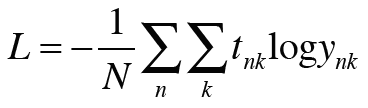

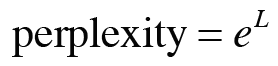

# RNNLM의 학습코드

In [1]:
import sys 
sys.path.append("..")
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset2 import ptb
from simple_rnnlm import SimpleRnnlm

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# 학습 데이터 load
corpus, word_to_id, id_to_word = ptb.load_data("train")
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

xs = corpus[:-1] # 입력
ts = corpus[1:] # 출력(정답레이블)
data_size = len(xs)

max_iters = data_size // (batch_size*time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []


# 모델 생성


model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size-1) // batch_size
offsets = [i*jump for i in range(batch_size)]

for epoch in range (max_epoch):
    for iter in range(max_iters):
        
        batch_x = np.empty((batch_size, time_size),dtype="i")
        batch_t = np.empty((batch_size, time_size),dtype="i")
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset+ time_idx) % data_size]
                batch_t[i, t] = ts[(offset+time_idx) % data_size]
                time_idx +=1
                
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
        ppl = np.exp(total_loss/ loss_count)
        print(": 에폭 %d :퍼플렉서티 %.2f"
             % (epoch+1, ppl))
        ppl_list.append(float(ppl))
        total_loss, loss_count = 0, 0


: 에폭 1 :퍼플렉서티 418.90
: 에폭 1 :퍼플렉서티 414.48
: 에폭 1 :퍼플렉서티 406.47
: 에폭 1 :퍼플렉서티 393.98
: 에폭 1 :퍼플렉서티 402.41
: 에폭 1 :퍼플렉서티 364.45
: 에폭 1 :퍼플렉서티 382.59
: 에폭 1 :퍼플렉서티 324.35
: 에폭 1 :퍼플렉서티 322.47
: 에폭 1 :퍼플렉서티 265.69
: 에폭 1 :퍼플렉서티 266.99
: 에폭 1 :퍼플렉서티 227.24
: 에폭 1 :퍼플렉서티 222.98
: 에폭 1 :퍼플렉서티 195.65
: 에폭 1 :퍼플렉서티 184.70
: 에폭 1 :퍼플렉서티 192.24
: 에폭 1 :퍼플렉서티 186.08
: 에폭 1 :퍼플렉서티 189.73
: 에폭 1 :퍼플렉서티 164.22
: 에폭 2 :퍼플렉서티 185.10
: 에폭 2 :퍼플렉서티 164.71
: 에폭 2 :퍼플렉서티 163.60
: 에폭 2 :퍼플렉서티 171.63
: 에폭 2 :퍼플렉서티 155.08
: 에폭 2 :퍼플렉서티 200.17
: 에폭 2 :퍼플렉서티 138.63
: 에폭 2 :퍼플렉서티 184.29
: 에폭 2 :퍼플렉서티 136.06
: 에폭 2 :퍼플렉서티 178.50
: 에폭 2 :퍼플렉서티 130.68
: 에폭 2 :퍼플렉서티 145.84
: 에폭 2 :퍼플렉서티 131.34
: 에폭 2 :퍼플렉서티 156.25
: 에폭 2 :퍼플렉서티 147.38
: 에폭 2 :퍼플렉서티 151.22
: 에폭 2 :퍼플렉서티 134.80
: 에폭 2 :퍼플렉서티 139.47
: 에폭 2 :퍼플렉서티 151.58
: 에폭 3 :퍼플렉서티 128.63
: 에폭 3 :퍼플렉서티 158.79
: 에폭 3 :퍼플렉서티 124.70
: 에폭 3 :퍼플렉서티 175.84
: 에폭 3 :퍼플렉서티 120.40
: 에폭 3 :퍼플렉서티 178.60
: 에폭 3 :퍼플렉서티 123.25
: 에폭 3 :퍼플렉서티 154.68
: 에폭 3 :퍼플렉서티 142.29
: 에폭 3 :퍼플렉서티

: 에폭 21 :퍼플렉서티 166.44
: 에폭 21 :퍼플렉서티 177.35
: 에폭 21 :퍼플렉서티 159.09
: 에폭 21 :퍼플렉서티 148.90
: 에폭 22 :퍼플렉서티 149.24
: 에폭 22 :퍼플렉서티 127.39
: 에폭 22 :퍼플렉서티 166.97
: 에폭 22 :퍼플렉서티 106.02
: 에폭 22 :퍼플렉서티 161.00
: 에폭 22 :퍼플렉서티 83.47
: 에폭 22 :퍼플렉서티 169.43
: 에폭 22 :퍼플렉서티 78.34
: 에폭 22 :퍼플렉서티 178.03
: 에폭 22 :퍼플렉서티 82.13
: 에폭 22 :퍼플렉서티 158.98
: 에폭 22 :퍼플렉서티 71.65
: 에폭 22 :퍼플렉서티 153.48
: 에폭 22 :퍼플렉서티 76.66
: 에폭 22 :퍼플렉서티 139.16
: 에폭 22 :퍼플렉서티 75.12
: 에폭 22 :퍼플렉서티 143.98
: 에폭 22 :퍼플렉서티 88.56
: 에폭 22 :퍼플렉서티 127.30
: 에폭 23 :퍼플렉서티 84.35
: 에폭 23 :퍼플렉서티 145.51
: 에폭 23 :퍼플렉서티 95.01
: 에폭 23 :퍼플렉서티 136.24
: 에폭 23 :퍼플렉서티 107.58
: 에폭 23 :퍼플렉서티 123.94
: 에폭 23 :퍼플렉서티 115.10
: 에폭 23 :퍼플렉서티 112.33
: 에폭 23 :퍼플렉서티 114.67
: 에폭 23 :퍼플렉서티 114.65
: 에폭 23 :퍼플렉서티 116.33
: 에폭 23 :퍼플렉서티 94.79
: 에폭 23 :퍼플렉서티 109.60
: 에폭 23 :퍼플렉서티 90.56
: 에폭 23 :퍼플렉서티 125.04
: 에폭 23 :퍼플렉서티 103.87
: 에폭 23 :퍼플렉서티 110.84
: 에폭 23 :퍼플렉서티 91.08
: 에폭 23 :퍼플렉서티 107.28
: 에폭 24 :퍼플렉서티 97.71
: 에폭 24 :퍼플렉서티 116.46
: 에폭 24 :퍼플렉서티 99.13
: 에폭 24 :퍼플렉서티 118.28
: 

: 에폭 42 :퍼플렉서티 133.30
: 에폭 42 :퍼플렉서티 110.73
: 에폭 42 :퍼플렉서티 108.84
: 에폭 42 :퍼플렉서티 125.42
: 에폭 42 :퍼플렉서티 113.45
: 에폭 42 :퍼플렉서티 124.52
: 에폭 42 :퍼플렉서티 117.81
: 에폭 42 :퍼플렉서티 114.16
: 에폭 42 :퍼플렉서티 117.79
: 에폭 42 :퍼플렉서티 122.91
: 에폭 42 :퍼플렉서티 135.60
: 에폭 42 :퍼플렉서티 137.31
: 에폭 42 :퍼플렉서티 180.46
: 에폭 43 :퍼플렉서티 120.14
: 에폭 43 :퍼플렉서티 123.97
: 에폭 43 :퍼플렉서티 94.42
: 에폭 43 :퍼플렉서티 117.82
: 에폭 43 :퍼플렉서티 88.51
: 에폭 43 :퍼플렉서티 107.08
: 에폭 43 :퍼플렉서티 84.19
: 에폭 43 :퍼플렉서티 102.83
: 에폭 43 :퍼플렉서티 83.95
: 에폭 43 :퍼플렉서티 99.62
: 에폭 43 :퍼플렉서티 89.53
: 에폭 43 :퍼플렉서티 103.22
: 에폭 43 :퍼플렉서티 83.84
: 에폭 43 :퍼플렉서티 89.01
: 에폭 43 :퍼플렉서티 73.66
: 에폭 43 :퍼플렉서티 83.08
: 에폭 43 :퍼플렉서티 81.88
: 에폭 43 :퍼플렉서티 117.09
: 에폭 43 :퍼플렉서티 86.12
: 에폭 44 :퍼플렉서티 95.67
: 에폭 44 :퍼플렉서티 87.62
: 에폭 44 :퍼플렉서티 93.13
: 에폭 44 :퍼플렉서티 86.38
: 에폭 44 :퍼플렉서티 92.12
: 에폭 44 :퍼플렉서티 86.69
: 에폭 44 :퍼플렉서티 97.53
: 에폭 44 :퍼플렉서티 88.38
: 에폭 44 :퍼플렉서티 95.09
: 에폭 44 :퍼플렉서티 85.83
: 에폭 44 :퍼플렉서티 99.58
: 에폭 44 :퍼플렉서티 72.91
: 에폭 44 :퍼플렉서티 86.53
: 에폭 44 :퍼플렉서티 79.15
: 에폭 44 :퍼플렉서티

: 에폭 63 :퍼플렉서티 70.39
: 에폭 63 :퍼플렉서티 137.21
: 에폭 63 :퍼플렉서티 68.49
: 에폭 63 :퍼플렉서티 157.43
: 에폭 63 :퍼플렉서티 87.73
: 에폭 63 :퍼플렉서티 208.94
: 에폭 63 :퍼플렉서티 84.87
: 에폭 63 :퍼플렉서티 158.19
: 에폭 63 :퍼플렉서티 63.02
: 에폭 63 :퍼플렉서티 144.92
: 에폭 63 :퍼플렉서티 71.10
: 에폭 63 :퍼플렉서티 134.31
: 에폭 63 :퍼플렉서티 74.80
: 에폭 63 :퍼플렉서티 108.93
: 에폭 63 :퍼플렉서티 82.89
: 에폭 63 :퍼플렉서티 115.02
: 에폭 63 :퍼플렉서티 102.82
: 에폭 63 :퍼플렉서티 120.32
: 에폭 63 :퍼플렉서티 94.68
: 에폭 64 :퍼플렉서티 90.24
: 에폭 64 :퍼플렉서티 93.15
: 에폭 64 :퍼플렉서티 77.87
: 에폭 64 :퍼플렉서티 96.91
: 에폭 64 :퍼플렉서티 66.31
: 에폭 64 :퍼플렉서티 102.56
: 에폭 64 :퍼플렉서티 58.84
: 에폭 64 :퍼플렉서티 125.73
: 에폭 64 :퍼플렉서티 120.34
: 에폭 64 :퍼플렉서티 319.86
: 에폭 64 :퍼플렉서티 133.79
: 에폭 64 :퍼플렉서티 340.79
: 에폭 64 :퍼플렉서티 118.82
: 에폭 64 :퍼플렉서티 253.45
: 에폭 64 :퍼플렉서티 73.60
: 에폭 64 :퍼플렉서티 89.58
: 에폭 64 :퍼플렉서티 53.54
: 에폭 64 :퍼플렉서티 112.72
: 에폭 64 :퍼플렉서티 67.10
: 에폭 65 :퍼플렉서티 90.47
: 에폭 65 :퍼플렉서티 56.93
: 에폭 65 :퍼플렉서티 93.17
: 에폭 65 :퍼플렉서티 63.20
: 에폭 65 :퍼플렉서티 87.51
: 에폭 65 :퍼플렉서티 69.95
: 에폭 65 :퍼플렉서티 85.58
: 에폭 65 :퍼플렉서티 89.77
: 에폭 65 :퍼플렉서티 

: 에폭 83 :퍼플렉서티 79.67
: 에폭 83 :퍼플렉서티 79.55
: 에폭 83 :퍼플렉서티 107.13
: 에폭 83 :퍼플렉서티 78.17
: 에폭 83 :퍼플렉서티 89.34
: 에폭 83 :퍼플렉서티 73.33
: 에폭 83 :퍼플렉서티 86.70
: 에폭 83 :퍼플렉서티 66.13
: 에폭 83 :퍼플렉서티 81.31
: 에폭 83 :퍼플렉서티 58.69
: 에폭 83 :퍼플렉서티 86.32
: 에폭 83 :퍼플렉서티 59.91
: 에폭 84 :퍼플렉서티 91.26
: 에폭 84 :퍼플렉서티 59.88
: 에폭 84 :퍼플렉서티 84.01
: 에폭 84 :퍼플렉서티 63.90
: 에폭 84 :퍼플렉서티 91.29
: 에폭 84 :퍼플렉서티 69.78
: 에폭 84 :퍼플렉서티 80.51
: 에폭 84 :퍼플렉서티 63.58
: 에폭 84 :퍼플렉서티 82.53
: 에폭 84 :퍼플렉서티 61.03
: 에폭 84 :퍼플렉서티 83.67
: 에폭 84 :퍼플렉서티 63.37
: 에폭 84 :퍼플렉서티 84.11
: 에폭 84 :퍼플렉서티 59.68
: 에폭 84 :퍼플렉서티 76.21
: 에폭 84 :퍼플렉서티 84.99
: 에폭 84 :퍼플렉서티 77.54
: 에폭 84 :퍼플렉서티 86.44
: 에폭 84 :퍼플렉서티 83.03
: 에폭 85 :퍼플렉서티 91.15
: 에폭 85 :퍼플렉서티 71.60
: 에폭 85 :퍼플렉서티 81.41
: 에폭 85 :퍼플렉서티 62.83
: 에폭 85 :퍼플렉서티 104.61
: 에폭 85 :퍼플렉서티 57.41
: 에폭 85 :퍼플렉서티 77.21
: 에폭 85 :퍼플렉서티 50.02
: 에폭 85 :퍼플렉서티 68.96
: 에폭 85 :퍼플렉서티 46.26
: 에폭 85 :퍼플렉서티 65.04
: 에폭 85 :퍼플렉서티 50.56
: 에폭 85 :퍼플렉서티 61.90
: 에폭 85 :퍼플렉서티 46.37
: 에폭 85 :퍼플렉서티 64.14
: 에폭 85 :퍼플렉서티 45.87
: 에폭 85 :퍼플

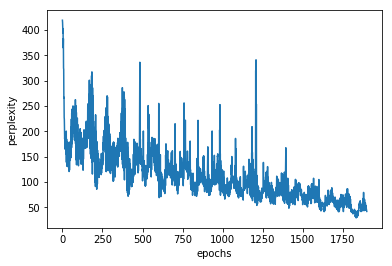

In [14]:
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

# RNNLM의 trainer class

In [51]:
...
from simple_rnnlm import SimpleRnnlm
from common.trainer import RnnlmTrainer 

...
model = SImpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)

NameError: name 'SImpleRnnlm' is not defined

# 정리  
## 1. RNN -> 순환하는 경로가 존재 (이를 통해 '은닉상태 저장')
## 2. 보통의 역전파를 통해 학습 가능
## 3. long-timeseries => 블록단위로 BPTT 실시
## 4. 언어 모델은 단어의 시퀀스를 확률로 해석 
